In [ ]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

from inference import get_model
import supervision as sv

ROBOFLOW_API_KEY = os.getenv("ROBOFLOW_API_KEY")
PLAYER_DETECTION_MODEL_ID = 'football-players-detection-3zvbc/2'
PLAYER_DETECTION_MODEL = get_model(PLAYER_DETECTION_MODEL_ID, ROBOFLOW_API_KEY)

SOURCE_VIDEO_PATH = "../../data/videos/old10s.mp4"

In [ ]:
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), #blue, pink, yellow
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), #blue, pink, yellow
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

In [ ]:
#Tracking IDs
BALL_ID = 0

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id -= 1 # remove ball class id
all_detections = tracker.update_with_detections(detections=all_detections)

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

In [ ]:
#Split teams
#use of the SigLIP, UMAP, and KMeans combo
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

PLAYER_ID = 2
STRIDE = 60
frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE
)

crops = []
for frame in tqdm(frame_generator, desc="collecting crops"):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    
    # Skip the frame if no players are detected
    if len(players_detections.xyxy) == 0:
        continue
    
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
    crops += players_crops

# Ensure there are enough crops for clustering
if len(crops) < 2:
    print("Not enough player crops detected. Skipping team classification.")
else:
    team_classifier = TeamClassifier(device="cpu")
    team_classifier.fit(crops)
    
print(f"Number of players detected: {len(crops)}")

In [ ]:
#GK Assignment - calculate avg centroid of players and assign GK to the team with the closest centroid

import numpy as np
import supervision as sv

def resolve_goalkeepers_team_id(
    players: sv.Detections,
    goalkeepers: sv.Detections
) -> np.ndarray:
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_id)

In [ ]:
#Tracking with team assignment and gk assignment

BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
    players_detections, goalkeepers_detections)

all_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections])

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

In [ ]:
#Pitch Keypoint Detection
from inference import get_model

ROBOFLOW_API_KEY = os.getenv("ROBOFLOW_API_KEY")
FIELD_DETECTION_MODEL_ID = "football-field-detection-f07vi/14"
FIELD_DETECTION_MODEL = get_model(model_id=FIELD_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

import supervision as sv

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

In [ ]:
#import field
from sports.annotators.soccer import draw_pitch
from sports.configs.soccer import SoccerPitchConfiguration

CONFIG = SoccerPitchConfiguration()

annotated_frame = draw_pitch(CONFIG)

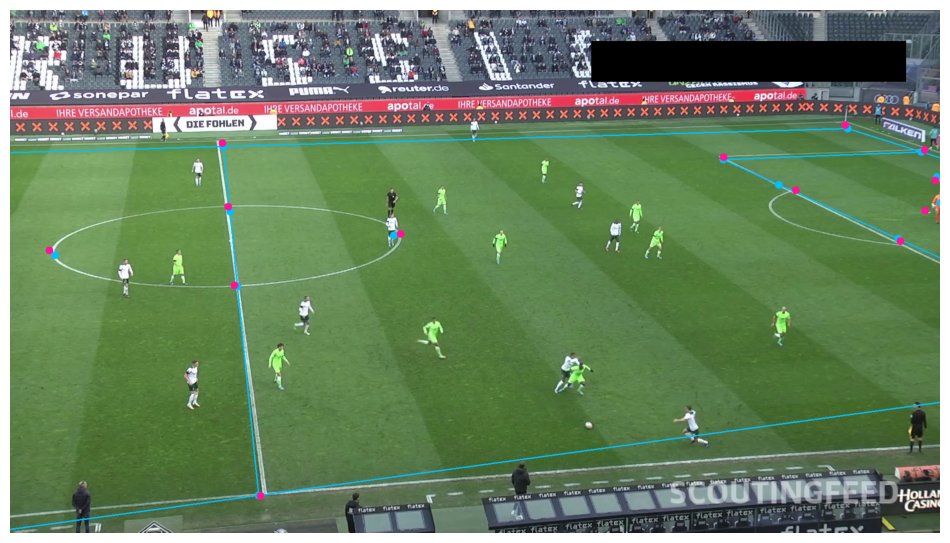

In [22]:
#project points and lines into the frame
import numpy as np
import supervision as sv
from sports.common.view import ViewTransformer

edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2, edges=CONFIG.edges)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)
vertex_annotator_2 = sv.VertexAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

# Filter keypoints based on confidence
filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

pitch_reference_points = np.array(CONFIG.vertices)[filter]

# Ensure there are at least 4 points for homography calculation
if len(frame_reference_points) < 4 or len(pitch_reference_points) < 4:
    print(f"Skipping frame {frame_index} due to insufficient keypoints: {len(frame_reference_points)} found.")
    
transformer = ViewTransformer(
    source=pitch_reference_points,
    target=frame_reference_points
)

pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = transformer.transform_points(points=pitch_all_points)

frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator_2.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

In [23]:
#frame generator
from tqdm import tqdm

frames = []

for frame_index, frame in enumerate(tqdm(sv.get_video_frames_generator(SOURCE_VIDEO_PATH), desc="Processing...")):
    if frame_index % 5 == 0: 
        frames.append(frame)

print(f"Total frames collected: {len(frames)}")

Processing...: 300it [00:04, 71.76it/s]


Total frames collected: 60


In [24]:
import supervision as sv
from sports.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch
)

pitch_frames = []
virt_frames = []

ball_coords = []
gk_t1_coords = []
gk_t2_coords = []

team_0_coords = []
team_1_coords = []

# Tracker
tracker = sv.ByteTrack()

for frame_index, frame in enumerate(tqdm(frames, desc="Processing...")):
    tqdm.write(f"Frame {frame_index}")

    # ball, goalkeeper, player, referee detection
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.4)[0]
    detections = sv.Detections.from_inference(result)

    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
    
    # Save ball coordinates
    if len(ball_detections.xyxy) > 0:
        x_min, y_min, x_max, y_max = ball_detections.xyxy[0]  # Assuming one ball per frame
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        ball_coords.append((frame_index, x_center, y_center))
    else:
        ball_coords.append((frame_index, None, None))  # No ball detected in this frame

    all_detections = detections[detections.class_id != BALL_ID]
    all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
    all_detections = tracker.update_with_detections(detections=all_detections)

    goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
    players_detections = all_detections[all_detections.class_id == PLAYER_ID]

    # team assignment
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
    players_detections.class_id = team_classifier.predict(players_crops)

    goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
        players_detections, goalkeepers_detections)
    
    # Save player coordinates per team (excluding goalkeepers)
    frame_team_0_coords = []
    frame_team_1_coords = []
    for player, team_id in zip(players_detections.xyxy, players_detections.class_id):
        x_min, y_min, x_max, y_max = player
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        if team_id == 0:
            frame_team_0_coords.append((x_center, y_center))  # Team 0 player coordinates
        elif team_id == 1:
            frame_team_1_coords.append((x_center, y_center))  # Team 1 player coordinates

    team_0_coords.append((frame_index, frame_team_0_coords))
    team_1_coords.append((frame_index, frame_team_1_coords))
    
    # Save goalkeeper coordinates for each team
    for gk, team_id in zip(goalkeepers_detections.xyxy, goalkeepers_detections.class_id):
        x_min, y_min, x_max, y_max = gk
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        if team_id == 0:
            gk_t1_coords.append((frame_index, x_center, y_center))
        elif team_id == 1:
            gk_t2_coords.append((frame_index, x_center, y_center))
    
    all_detections = sv.Detections.merge([players_detections, goalkeepers_detections])

    # frame visualization
    labels = [
        f"#{tracker_id}"
        for tracker_id
        in all_detections.tracker_id
    ]

    all_detections.class_id = all_detections.class_id.astype(int)

    annotated_frame = frame.copy()
    annotated_frame = ellipse_annotator.annotate(
        scene=annotated_frame,
        detections=all_detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=all_detections,
        labels=labels)
    annotated_frame = triangle_annotator.annotate(
        scene=annotated_frame,
        detections=ball_detections)

    pitch_frames.append(annotated_frame.copy())
    
    players_detections = sv.Detections.merge([
        players_detections, goalkeepers_detections
    ])

    # detect pitch key points
    result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    key_points = sv.KeyPoints.from_inference(result)
    
    # Ensure key_points is not None and contains valid data
    if key_points is None or key_points.confidence is None:
        print(f"Skipping frame {frame_index} due to missing key points.")
        continue  # Skip this frame and move to the next one

    # project ball, players and gk on pitch
    filter = key_points.confidence[0] > 0.5
    frame_reference_points = key_points.xy[0][filter]
    pitch_reference_points = np.array(CONFIG.vertices)[filter]

    # Ensure there are at least 4 points for homography calculation
    if len(frame_reference_points) < 4 or len(pitch_reference_points) < 4:
        print(f"Skipping frame due to insufficient keypoints: {len(frame_reference_points)} found.")
        continue  # Skip this frame and move to the next one

    # Proceed with homography calculation
    transformer = ViewTransformer(
        source=frame_reference_points,
        target=pitch_reference_points
    )

    frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

    players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_players_xy = transformer.transform_points(points=players_xy)

    # visualize video game-style radar view
    annotated_frame = draw_pitch(CONFIG)
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_ball_xy,
        face_color=sv.Color.WHITE,
        edge_color=sv.Color.BLACK,
        radius=10,
        pitch=annotated_frame)
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_players_xy[players_detections.class_id == 0],
        face_color=sv.Color.from_hex('00BFFF'),
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=annotated_frame)
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_players_xy[players_detections.class_id == 1],
        face_color=sv.Color.from_hex('FF1493'),
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=annotated_frame)

    virt_frames.append(annotated_frame.copy())  
    
    #tracker.reset() 

Frame 0


Processing...:   0%|          | 0/60 [00:00<?, ?it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:08,  8.01s/it]


Frame 1


Processing...:   2%|▏         | 1/60 [00:11<11:44, 11.93s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:08,  8.70s/it]


Frame 2


Processing...:   3%|▎         | 2/60 [00:25<12:21, 12.78s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:07,  7.92s/it]


Frame 3


Processing...:   5%|▌         | 3/60 [00:37<11:41, 12.30s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.23s/it]


Frame 4


Processing...:   7%|▋         | 4/60 [00:47<10:47, 11.57s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.42s/it]


Frame 5


Processing...:   8%|▊         | 5/60 [00:56<09:45, 10.64s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.71s/it]


Frame 6


Processing...:  10%|█         | 6/60 [01:07<09:43, 10.81s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:07,  7.14s/it]


Frame 7


Processing...:  12%|█▏        | 7/60 [01:18<09:31, 10.78s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.80s/it]


Frame 8


Processing...:  13%|█▎        | 8/60 [01:27<08:53, 10.26s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:07,  7.28s/it]


Frame 9


Processing...:  15%|█▌        | 9/60 [01:38<08:51, 10.43s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.29s/it]


Frame 10


Processing...:  17%|█▋        | 10/60 [01:46<08:09,  9.78s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.61s/it]


Frame 11


Processing...:  18%|█▊        | 11/60 [01:55<07:40,  9.41s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.28s/it]


Frame 12


Processing...:  20%|██        | 12/60 [02:04<07:31,  9.41s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.20s/it]


Frame 13


Processing...:  22%|██▏       | 13/60 [02:12<07:05,  9.05s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.04s/it]


Frame 14


Processing...:  23%|██▎       | 14/60 [02:20<06:42,  8.76s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.98s/it]


Frame 15


Processing...:  25%|██▌       | 15/60 [02:28<06:22,  8.50s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.22s/it]


Frame 16


Processing...:  27%|██▋       | 16/60 [02:36<06:09,  8.40s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.43s/it]


Frame 17


Processing...:  28%|██▊       | 17/60 [02:45<05:58,  8.34s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.88s/it]


Frame 18


Processing...:  30%|███       | 18/60 [02:53<05:44,  8.21s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.75s/it]


Frame 19


Processing...:  32%|███▏      | 19/60 [03:00<05:28,  8.00s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.19s/it]


Frame 20


Processing...:  33%|███▎      | 20/60 [03:08<05:21,  8.04s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.36s/it]


Frame 21


Processing...:  35%|███▌      | 21/60 [03:16<05:05,  7.82s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:03,  3.96s/it]


Frame 22


Processing...:  37%|███▋      | 22/60 [03:22<04:43,  7.46s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:03,  3.68s/it]


Frame 23


Processing...:  38%|███▊      | 23/60 [03:29<04:23,  7.13s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.40s/it]


Frame 24


Processing...:  40%|████      | 24/60 [03:36<04:16,  7.13s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.15s/it]


Frame 25


Processing...:  42%|████▏     | 25/60 [03:43<04:07,  7.07s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.42s/it]


Frame 26


Processing...:  43%|████▎     | 26/60 [03:50<04:01,  7.09s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.43s/it]


Frame 27


Processing...:  45%|████▌     | 27/60 [03:57<03:59,  7.25s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.16s/it]


Frame 28


Processing...:  47%|████▋     | 28/60 [04:05<03:58,  7.46s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:01,  1.77s/it]


Frame 29


Processing...:  48%|████▊     | 29/60 [04:10<03:22,  6.52s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:02,  2.18s/it]


Frame 30


Processing...:  50%|█████     | 30/60 [04:14<02:59,  5.99s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:02,  2.36s/it]


Frame 31


Processing...:  52%|█████▏    | 31/60 [04:20<02:46,  5.76s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:02,  2.68s/it]


Frame 32


Processing...:  53%|█████▎    | 32/60 [04:26<02:45,  5.91s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:03,  3.58s/it]


Frame 33


Processing...:  55%|█████▌    | 33/60 [04:33<02:46,  6.16s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.58s/it]


Frame 34


Processing...:  57%|█████▋    | 34/60 [04:41<02:58,  6.85s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.47s/it]


Frame 35


Processing...:  58%|█████▊    | 35/60 [04:49<02:58,  7.16s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.74s/it]


Frame 36


Processing...:  60%|██████    | 36/60 [04:57<02:55,  7.33s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.36s/it]


Frame 37


Processing...:  62%|██████▏   | 37/60 [05:06<03:00,  7.84s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:08,  8.77s/it]


Frame 38


Processing...:  63%|██████▎   | 38/60 [05:19<03:25,  9.35s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.54s/it]


Frame 39


Processing...:  65%|██████▌   | 39/60 [05:27<03:10,  9.08s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.88s/it]


Frame 40


Processing...:  67%|██████▋   | 40/60 [05:38<03:11,  9.57s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.25s/it]


Frame 41


Processing...:  68%|██████▊   | 41/60 [05:47<02:58,  9.38s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.37s/it]


Frame 42


Processing...:  70%|███████   | 42/60 [05:57<02:52,  9.58s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:07,  7.21s/it]


Frame 43


Processing...:  72%|███████▏  | 43/60 [06:08<02:49, 10.00s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:07,  7.11s/it]


Frame 44


Processing...:  73%|███████▎  | 44/60 [06:18<02:43, 10.23s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.16s/it]


Frame 45


Processing...:  75%|███████▌  | 45/60 [06:28<02:30, 10.00s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.48s/it]


Frame 46


Processing...:  77%|███████▋  | 46/60 [06:37<02:15,  9.67s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.91s/it]


Frame 47


Processing...:  78%|███████▊  | 47/60 [06:46<02:04,  9.58s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.99s/it]


Frame 48


Processing...:  80%|████████  | 48/60 [06:57<01:58,  9.87s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.33s/it]


Frame 49


Processing...:  82%|████████▏ | 49/60 [07:06<01:45,  9.63s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.04s/it]


Frame 50


Processing...:  83%|████████▎ | 50/60 [07:15<01:33,  9.38s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.81s/it]


Frame 51


Processing...:  85%|████████▌ | 51/60 [07:24<01:23,  9.32s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.52s/it]


Frame 52


Processing...:  87%|████████▋ | 52/60 [07:32<01:12,  9.12s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.90s/it]


Frame 53


Processing...:  88%|████████▊ | 53/60 [07:41<01:01,  8.81s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.45s/it]


Frame 54


Processing...:  90%|█████████ | 54/60 [07:51<00:55,  9.22s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.48s/it]


Frame 55


Processing...:  92%|█████████▏| 55/60 [07:59<00:45,  9.04s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.37s/it]


Frame 56


Processing...:  93%|█████████▎| 56/60 [08:10<00:37,  9.43s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.18s/it]


Frame 57


Processing...:  95%|█████████▌| 57/60 [08:20<00:28,  9.58s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.05s/it]


Frame 58


Processing...:  97%|█████████▋| 58/60 [08:29<00:19,  9.55s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:06,  6.27s/it]


Frame 59


Processing...:  98%|█████████▊| 59/60 [08:39<00:09,  9.69s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:07,  7.33s/it]
Processing...: 100%|██████████| 60/60 [08:50<00:00,  8.84s/it]


In [28]:
import cv2
import numpy as np

output_dir = "../../data/frames/old10s"
os.makedirs(output_dir, exist_ok=True)

# Exemplo de como salvar os frames:
for idx, frame in enumerate(pitch_frames):
    frame_path = os.path.join(output_dir, f"frame_{idx:04d}.png")
    # Converter de RGB para BGR antes de salvar com OpenCV
    cv2.imwrite(frame_path,np.array(frame))

In [29]:
import pandas as pd
import csv

output_csv_path = "../../data/coords/old10s.csv"

# Descobrir todos os IDs únicos de cada time
team_0_ids = set()
team_1_ids = set()
for _, players in team_0_coords:
    for player in players:
        if isinstance(player, tuple) and len(player) == 3:
            team_0_ids.add(player[2])  # (x, y, id)
for _, players in team_1_coords:
    for player in players:
        if isinstance(player, tuple) and len(player) == 3:
            team_1_ids.add(player[2])

team_0_ids = sorted(team_0_ids)
team_1_ids = sorted(team_1_ids)

# Criar header dinâmico
header = [
    "frame_index",
    "ball",
    "gk_t1",
    "gk_t2"
]
for id in team_0_ids:
    header.append(f"team_0_id_{id}")
for id in team_1_ids:
    header.append(f"team_1_id_{id}")

with open(output_csv_path, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(header)
    for frame_index, ball_x, ball_y in ball_coords:
        # Goleiros
        gk_t1_pos = next((pos for pos in gk_t1_coords if pos[0] == frame_index), (None, None, None))
        gk_t2_pos = next((pos for pos in gk_t2_coords if pos[0] == frame_index), (None, None, None))
        # Jogadores por ID
        team_0_players = next((coords for idx, coords in team_0_coords if idx == frame_index), [])
        team_1_players = next((coords for idx, coords in team_1_coords if idx == frame_index), [])
        team_0_dict = {p[2]: [p[0], p[1]] for p in team_0_players if len(p) == 3}
        team_1_dict = {p[2]: [p[0], p[1]] for p in team_1_players if len(p) == 3}
        row = [
            frame_index,
            [ball_x, ball_y] if ball_x is not None and ball_y is not None else "",
            [gk_t1_pos[1], gk_t1_pos[2]] if gk_t1_pos[1] is not None else "",
            [gk_t2_pos[1], gk_t2_pos[2]] if gk_t2_pos[1] is not None else "",
        ]
        for id in team_0_ids:
            row.append(team_0_dict.get(id, ""))
        for id in team_1_ids:
            row.append(team_1_dict.get(id, ""))
        writer.writerow(row)

print(f"Coordinates saved to {output_csv_path}")

Coordinates saved to ../../data/coords/old10s.csv
